In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transforms.ToTensor())
testset  = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())

batch_size      = 64
test_batch_size = 1000

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

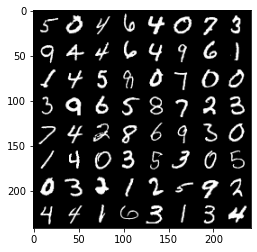

In [3]:
def imshow(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)).mean(2), cmap="gray")
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.125)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [5]:
def get_lnorm(model, l_norm=2, alpha=0.001):
    return sum(alpha*torch.norm(param, l_norm) ** l_norm for param in model.parameters())

def train(model, optimizer, epoch, reg=None, regularization=None):
    model.train()
    losses = []
    r = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if reg:
            r = get_lnorm(model, reg)
        loss = F.nll_loss(output, target) + r
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        log_train(epoch, batch_idx, loss)
    return np.mean(losses)

def test(model, reg=None):
    model.eval()
    test_loss = 0
    correct = 0
    r = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if reg:
                r = get_lnorm(model, reg)
            test_loss += F.nll_loss(output, target, reduction='sum').item() + r
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)
    error = 1 - acc

    if log_interval:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return test_loss, error

In [6]:
import torch.optim as optim
from time import time

def log_train(epoch, batch_idx, loss):
    if log_interval and batch_idx % log_interval == 0:
        p_done = 100. * batch_idx / len(train_loader)
        ntotal = len(train_loader.dataset)
        nprocessed = batch_idx * batch_size
        print(f"Train Epoch: {epoch} [{nprocessed: >5}/{ntotal} ({p_done: >2.0f}%)]\tLoss: {loss:.6f}")

def init_params(init):
    def __init_params(m):
        init(m.weight)
        m.bias.data.fill(1e-6)
    return init_params

def fit_model(model, Optimizer=optim.Adadelta, epochs=15, init=None):
    train_loss = []
    test_loss = []
    test_errors = []
    start = time()
    model.to(device)
    optimizer = Optimizer(model.parameters(), lr=1e-3)
    initializer = init_params(init)
    model.apply(initializer)
    for epoch in range(1, epochs + 1):
        loss = train(model, optimizer, epoch)
        train_loss.append(loss)
        loss, error = test(model)
        test_loss.append(loss)
        test_errors.append(error)
    print(f'Done training after {time() - start:.2f} s')

    return model, train_loss, test_loss, test_errors

In [7]:
from torch.nn.init import *
import torch.optim as optim

epochs = 10
initializers = {'xavier_uniform': xavier_uniform_,
                'xavier_normal': xavier_normal_, 
                'kaiming_uniform': kaiming_uniform_,
                'kaiming_normal': kaiming_normal_}

log_interval = 100
optimizers = [optim.SGD, optim.Adadelta, optim.Adagrad]
results = {}
for optimizer in optimizers:
    optimizer_name = str(optimizer).split(".")[-1][:-2]
    print(f"\nTraining with {optimizer_name}")

    optim_results = {}
    for name, init in initializers.items():
        t = fit_model(Net(), init=init, epochs=epochs, Optimizer=optimizer)
        model, train_loss, test_loss, test_errors = t
        optim_results[name] = {'model': model, 'train_loss': train_loss, 'test_loss':test_loss, 'test_errors': test_errors}
    results[optimizer] = optim_results


Training with SGD
Train Epoch: 1 [    0/60000 ( 0%)]	Loss: 2.308742
Train Epoch: 1 [ 6400/60000 (11%)]	Loss: 2.298423
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.308676
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.309097
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.316245
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.294571
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.301366
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.279705
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.280051
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.281398

Test set: Average loss: 2.2839, Accuracy: 2572/10000 (26%)

Train Epoch: 2 [    0/60000 ( 0%)]	Loss: 2.287226
Train Epoch: 2 [ 6400/60000 (11%)]	Loss: 2.264482
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.279922
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.264389
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.262849
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.266698
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.269520
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.256949
Train Epoch: 2 [5120

Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.807082
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.792589
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.710064
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.775967

Test set: Average loss: 0.4900, Accuracy: 8742/10000 (87%)

Train Epoch: 6 [    0/60000 ( 0%)]	Loss: 0.752641
Train Epoch: 6 [ 6400/60000 (11%)]	Loss: 0.599375
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.494326
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.591424
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.561146
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.571869
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.402928
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.511208
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.576907
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.477990

Test set: Average loss: 0.4049, Accuracy: 8924/10000 (89%)

Train Epoch: 7 [    0/60000 ( 0%)]	Loss: 0.678299
Train Epoch: 7 [ 6400/60000 (11%)]	Loss: 0.676789
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.837940
Train Epoch: 7 [19200/60000 

Train Epoch: 10 [ 6400/60000 (11%)]	Loss: 0.312569
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.280961
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.360978
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.245621
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.401300
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.340169
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.510904
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.428721
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.330385

Test set: Average loss: 0.2577, Accuracy: 9234/10000 (92%)

Done training after 89.91 s
Train Epoch: 1 [    0/60000 ( 0%)]	Loss: 2.310889
Train Epoch: 1 [ 6400/60000 (11%)]	Loss: 2.337508
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.283210
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.299337
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.296303
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.282610
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.262494
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.264958
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.258467
Tr

Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.769573
Train Epoch: 4 [44800/60000 (75%)]	Loss: 1.727314
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.723907
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.570008

Test set: Average loss: 1.5431, Accuracy: 7085/10000 (71%)

Train Epoch: 5 [    0/60000 ( 0%)]	Loss: 1.656238
Train Epoch: 5 [ 6400/60000 (11%)]	Loss: 1.661283
Train Epoch: 5 [12800/60000 (21%)]	Loss: 1.572771
Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.522475
Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.405625
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.312079
Train Epoch: 5 [38400/60000 (64%)]	Loss: 1.455943
Train Epoch: 5 [44800/60000 (75%)]	Loss: 1.220188
Train Epoch: 5 [51200/60000 (85%)]	Loss: 1.297763
Train Epoch: 5 [57600/60000 (96%)]	Loss: 1.169553

Test set: Average loss: 1.1047, Accuracy: 7802/10000 (78%)

Train Epoch: 6 [    0/60000 ( 0%)]	Loss: 1.340955
Train Epoch: 6 [ 6400/60000 (11%)]	Loss: 1.113240
Train Epoch: 6 [12800/60000 (21%)]	Loss: 1.128762
Train Epoch: 6 [19200/60000 

Train Epoch: 9 [ 6400/60000 (11%)]	Loss: 0.932451
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.798841
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.613826
Train Epoch: 9 [25600/60000 (43%)]	Loss: 1.054060
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.692155
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.780694
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.722844
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.605861
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.529621

Test set: Average loss: 0.5013, Accuracy: 8776/10000 (88%)

Train Epoch: 10 [    0/60000 ( 0%)]	Loss: 0.813494
Train Epoch: 10 [ 6400/60000 (11%)]	Loss: 0.515229
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.714239
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.841078
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.777774
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.590598
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.672734
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.845939
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.630585
Train Epoch: 10 [57600/60000 (

Train Epoch: 3 [44800/60000 (75%)]	Loss: 1.957071
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.893803
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.837675

Test set: Average loss: 1.8178, Accuracy: 7112/10000 (71%)

Train Epoch: 4 [    0/60000 ( 0%)]	Loss: 1.888129
Train Epoch: 4 [ 6400/60000 (11%)]	Loss: 1.825304
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.783047
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.672985
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.679365
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.514577
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.464162
Train Epoch: 4 [44800/60000 (75%)]	Loss: 1.507410
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.539498
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.311757

Test set: Average loss: 1.2847, Accuracy: 7586/10000 (76%)

Train Epoch: 5 [    0/60000 ( 0%)]	Loss: 1.455118
Train Epoch: 5 [ 6400/60000 (11%)]	Loss: 1.465121
Train Epoch: 5 [12800/60000 (21%)]	Loss: 1.429711
Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.131232
Train Epoch: 5 [25600/60000 

Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.292795
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.191611
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.170733
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.191397
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.118767
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.141200
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.283363
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.148354

Test set: Average loss: 0.1245, Accuracy: 9630/10000 (96%)

Train Epoch: 9 [    0/60000 ( 0%)]	Loss: 0.240301
Train Epoch: 9 [ 6400/60000 (11%)]	Loss: 0.259053
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.385815
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.158436
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.169440
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.290236
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.185887
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.138992
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.103988
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.465976

Test set: Average loss: 0.1185, Accura

Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.415557
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.385329

Test set: Average loss: 0.2225, Accuracy: 9304/10000 (93%)

Train Epoch: 3 [    0/60000 ( 0%)]	Loss: 0.259377
Train Epoch: 3 [ 6400/60000 (11%)]	Loss: 0.321843
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.477070
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.368442
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.412814
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.134178
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.445726
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.373944
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.350590
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.275299

Test set: Average loss: 0.1947, Accuracy: 9400/10000 (94%)

Train Epoch: 4 [    0/60000 ( 0%)]	Loss: 0.238477
Train Epoch: 4 [ 6400/60000 (11%)]	Loss: 0.364299
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.228679
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.331279
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.220431
Train Epoch: 4 [32000/60000 

Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.259932
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.154549
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.281333
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.074949
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.303182
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.169752
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.207622

Test set: Average loss: 0.1069, Accuracy: 9668/10000 (97%)

Train Epoch: 8 [    0/60000 ( 0%)]	Loss: 0.099933
Train Epoch: 8 [ 6400/60000 (11%)]	Loss: 0.206649
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.138508
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.259417
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.304660
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.200853
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.209469
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.076621
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.093352
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.212347

Test set: Average loss: 0.0996, Accuracy: 9684/10000 (97%)

Train Epoch: 9 [    0/60000 

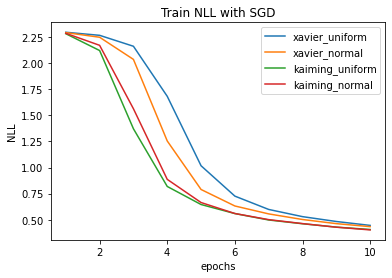

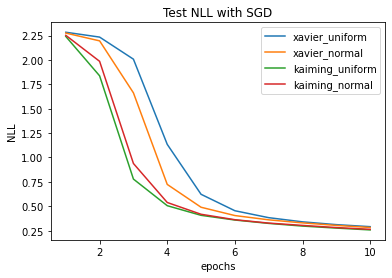

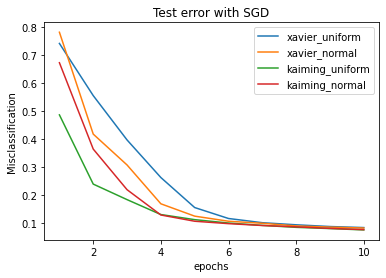

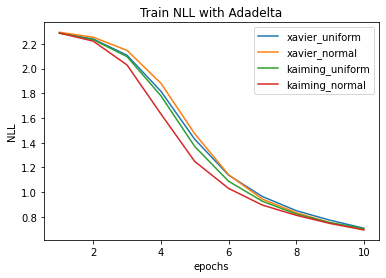

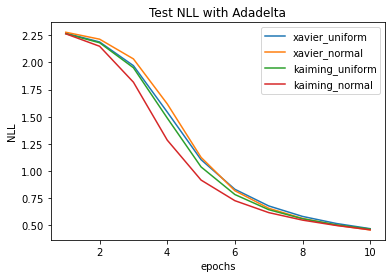

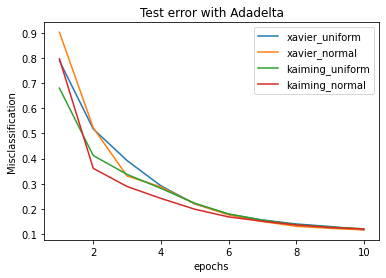

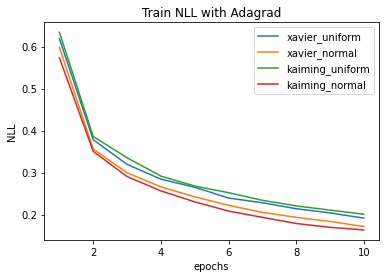

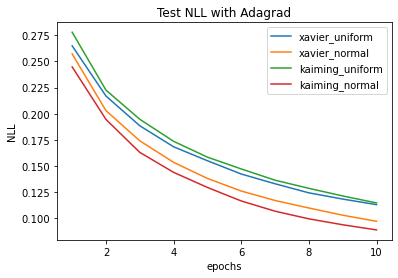

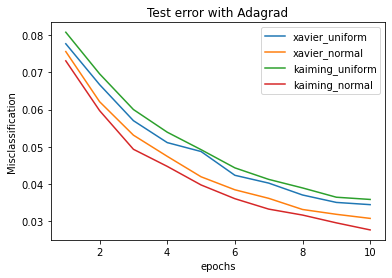

In [8]:
for optimizer in optimizers:
    optimizer_name = str(optimizer).split(".")[-1][:-2]
    optim_results = results[optimizer]
    x = np.arange(epochs)+1

    for key, val in initializers.items():
        result = optim_results[key]
        plt.plot(x, result["train_loss"], label=f"{key}")
    plt.title(f"Train NLL with {optimizer_name}")
    plt.xlabel("epochs")
    plt.ylabel("NLL")
    plt.legend()
    plt.savefig(f"img/init-train-loss-{optimizer_name}.pdf")
    plt.show()

    for key, val in initializers.items():
        result = optim_results[key]
        plt.plot(x, result["test_loss"], label=f"{key}")
    plt.title(f"Test NLL with {optimizer_name}")
    plt.xlabel("epochs")
    plt.ylabel("NLL")
    plt.legend()
    plt.savefig(f"img/init-test-loss-{optimizer_name}.pdf")
    plt.show()

    for key, val in initializers.items():
        result = optim_results[key]
        plt.plot(x, result["test_errors"], label=f"{key}")
    plt.title(f"Test error with {optimizer_name}")
    plt.xlabel("epochs")
    plt.ylabel("Misclassification")
    plt.legend()
    plt.savefig(f"img/init-test-error-{optimizer_name}.pdf")
    plt.show()
